## Импорт пакетов и загрузка данных

In [33]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

import re
import pymorphy2
import nltk
from nltk.corpus import stopwords

from multiprocessing import Pool as PoolSklearn
from tqdm import tqdm
from functools import lru_cache
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train_ml.csv')
df

,bank,feeds,grades,date
0,ubrr,"Много лет являюсь клиентом этого банка, но пос...",1.0,16.02.2017 16:10
1,fk_otkritie,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",2.0,13.12.2016 1:05
2,alfabank,Здравствуйте!Ранее уже оставлял отзыв о вашем ...,NaN,28.06.2019 13:54
3,vtb,Обращаюсь к Вам с жалобой на незаконное списан...,NaN,15.07.2020 14:54
4,promsvyazbank,"Имею потребительский кредит, взятый в Связь-ба...",2.0,04.08.2020 6:38
...,...,...,...,...
74995,trust,Три года длится эпопея с закрытием кредитной к...,1.0,26.10.2016 11:03
74996,fk_otkritie,"Являлся клиентом Бинбанка, пока после слияния ...",2.0,01.02.2020 21:07
74997,sberbank,8 мая 2016 г. мною вносились деньги на банковс...,1.0,14.06.2016 16:03
74998,uralsib,Здравствуйте! Сегодня 21.04.2020 захожу в моби...,3.0,21.04.2020 8:24


## EDA

In [3]:
df.grades.value_counts().sort_index()

1.0    27739
2.0     5634
3.0     2356
4.0     1520
5.0    14227
Name: grades, dtype: int64

In [4]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M')
df.dropna(inplace=True)
df = df.astype({'grades': 'int32'})
df.sample(10)

,bank,feeds,grades,date
14499,sberbank,За свои 48 лет жизни мне приходилось много общ...,5,2018-02-02 22:44:00
71633,sberbank,"Доброго времени суток! Я, С-ва О.В., являюсь в...",1,2018-07-06 21:47:00
23600,sberbank,Сотрудничаю со Сбербанком давно. Уже несколько...,3,2017-04-17 10:54:00
35294,sovcombank,Вообще у меня прекрасное мнение о Халве и о Кр...,3,2020-11-01 17:31:00
22345,sberbank,Добрый день.В августе 2010 года открыл карту M...,1,2011-01-05 21:04:00
7121,ubrr,В связи с в конец испортившимися условиями про...,1,2021-03-07 08:37:00
74557,vtb,Пользуюсь банком ВТБ более 10 лет.Не ожидал та...,1,2018-05-29 09:58:00
51252,rsb,Добрый день! Я была клиентом вашего банка до к...,1,2017-03-12 20:20:00
65991,sovcombank,Добрый день.хочу выразить благодарность и восх...,5,2019-09-13 17:00:00
38938,citibank,Невозможно совершить внешний перевод через моб...,1,2015-01-13 11:57:00


In [5]:
### Создаем новые столбцы на основе даты - год, месяц, день, время суток

def time_of_day(hour):
    if 0 <= hour < 6:
        return 'night'
    elif 6 <= hour < 12:
        return 'morning'
    if 12 <= hour < 18:
        return 'afternoon'
    if 18 <= hour < 24:
        return 'evening'

df['year'] = df['date'].apply(lambda x: x.year)
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['time_day'] = df['date'].apply(lambda x: time_of_day(x.hour))

In [6]:
df

,bank,feeds,grades,year,month,day,time_day
0,ubrr,"Много лет являюсь клиентом этого банка, но пос...",1,2017,2,16,afternoon
1,fk_otkritie,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",2,2016,12,13,night
4,promsvyazbank,"Имею потребительский кредит, взятый в Связь-ба...",2,2020,8,4,morning
7,homecreditbank,Хочу выразить глубокую благодарность всем сотр...,5,2015,4,19,evening
8,vtb,"6 марта 2019г. В 10:33 при проходе в метро ""Ку...",2,2019,3,28,evening
...,...,...,...,...,...,...,...
74995,trust,Три года длится эпопея с закрытием кредитной к...,1,2016,10,26,morning
74996,fk_otkritie,"Являлся клиентом Бинбанка, пока после слияния ...",2,2020,2,1,evening
74997,sberbank,8 мая 2016 г. мною вносились деньги на банковс...,1,2016,6,14,afternoon
74998,uralsib,Здравствуйте! Сегодня 21.04.2020 захожу в моби...,3,2020,4,21,morning


### Посмотрим на распределения

In [7]:
# Распределение отзывов по банкам

feeds_bank = df.bank.value_counts()
feeds_bank

# всего 69 банков в выборке

sberbank        8355
vtb             5255
tcs             4503
sovcombank      2600
fk_otkritie     2599
                ... 
sdm-bank          33
intesa            31
primsotsbank      31
rncb              30
rnbank            26
Name: bank, Length: 69, dtype: int64

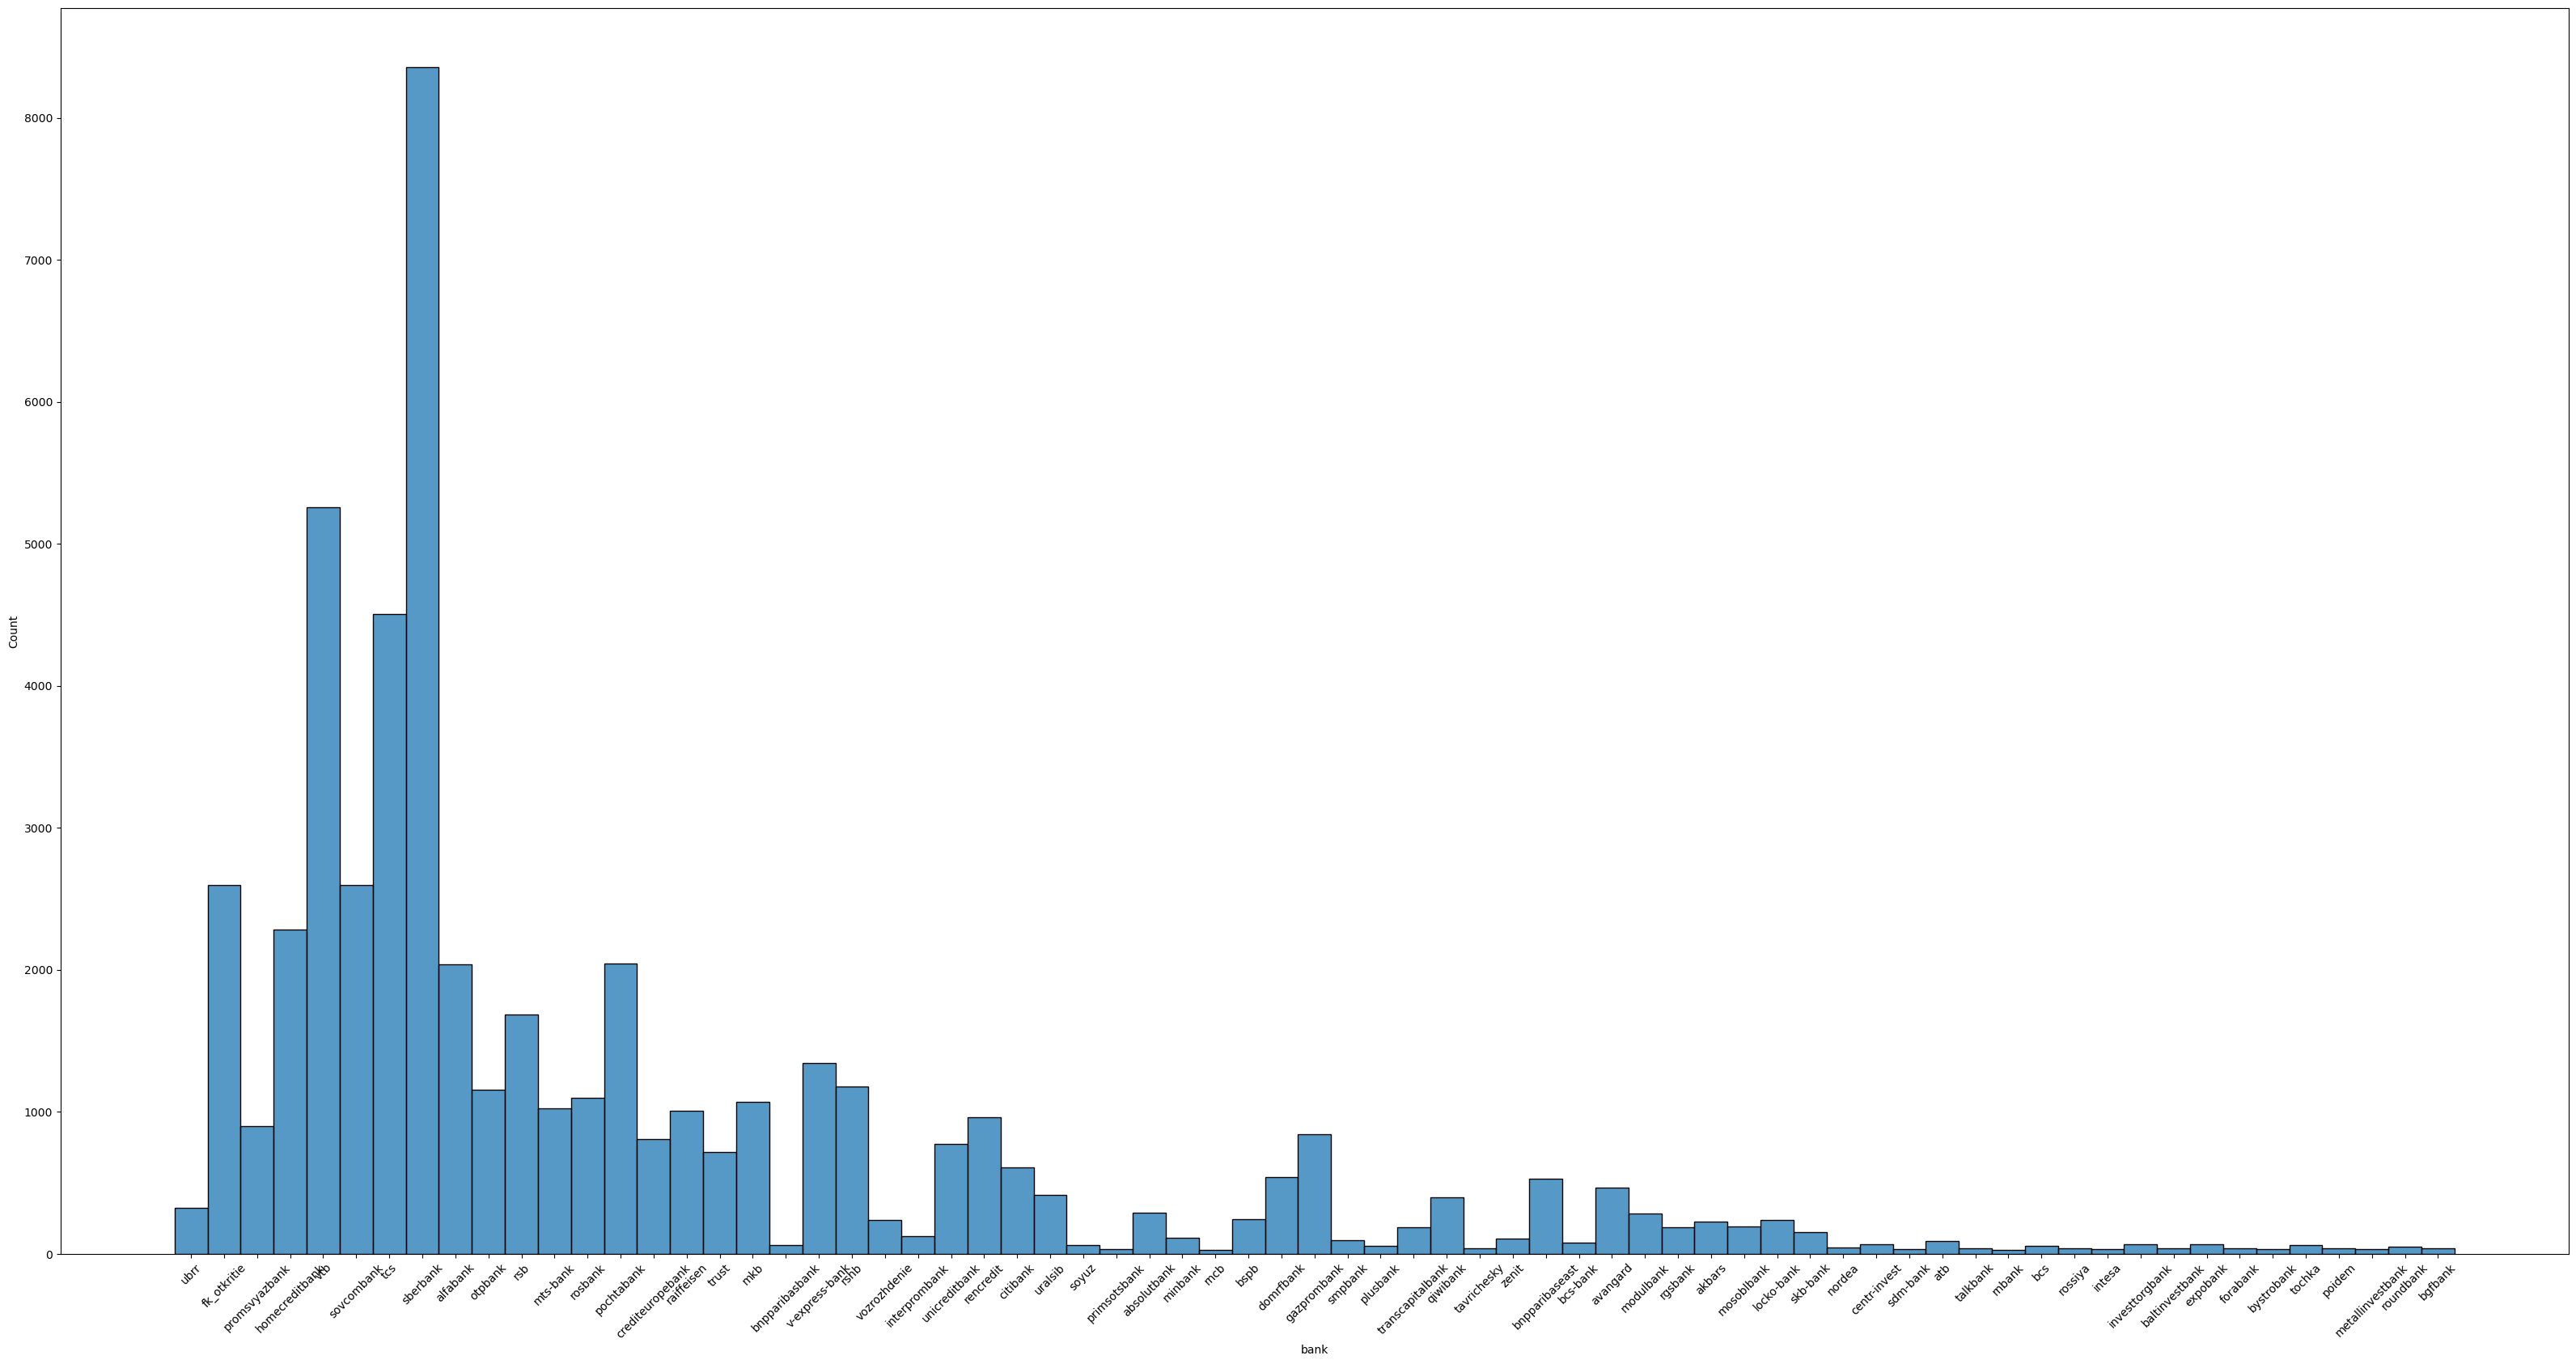

In [8]:
plt.figure(figsize=(40,20))
sns.histplot(data=df.sort_values(by='bank'), 
             x=df.bank)
plt.xticks(rotation=45)
plt.show()

# больше всего отзывов для сбербанка, банка homecredit, тинькофф банка

In [9]:
# Распределение выставленных оценок

df.grades.value_counts().sort_index()

1    27739
2     5634
3     2356
4     1520
5    14227
Name: grades, dtype: int64

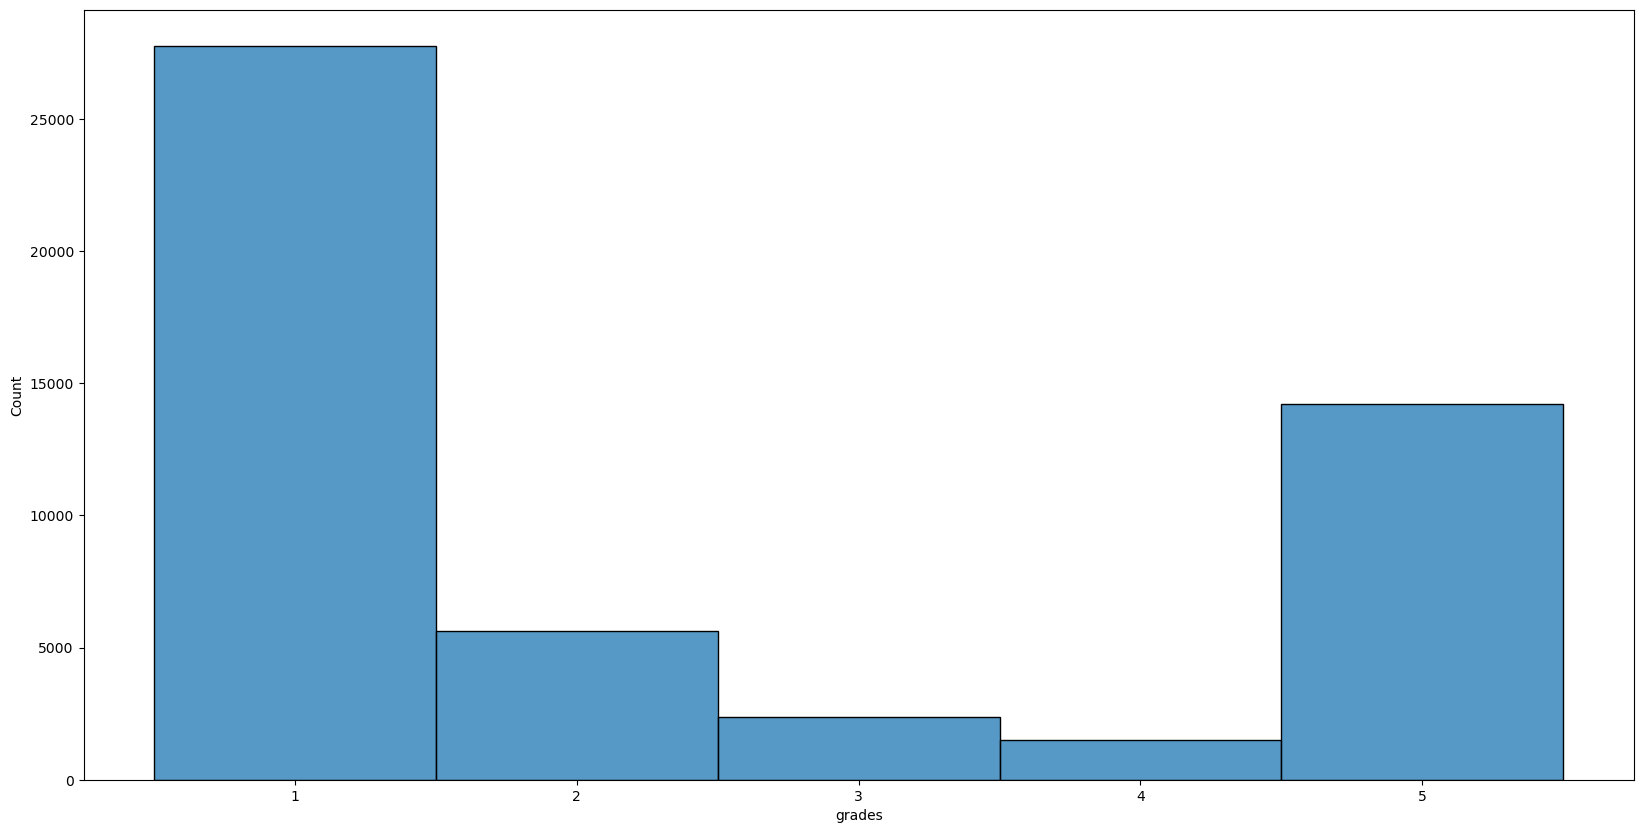

In [10]:
plt.figure(figsize=(20, 10))
sns.histplot(data=df, 
             x=df.grades,
             bins=5, 
             discrete=True)
plt.show()

# Видим, что больше всего оценок 1 и 5, что может привести к 
# очень редкому появлению оценок 2,3,4 и в предсказаниях моделей
# (модели могут переобучиться и выдавать только 1,5)

In [11]:
# Посмотрим на распределение длин отзывов

df['feed_len'] = df.feeds.apply(len) # количество символов в тексте
df['words_num'] = df.feeds.apply(lambda x: len(x.split())) # количество слов в тексте

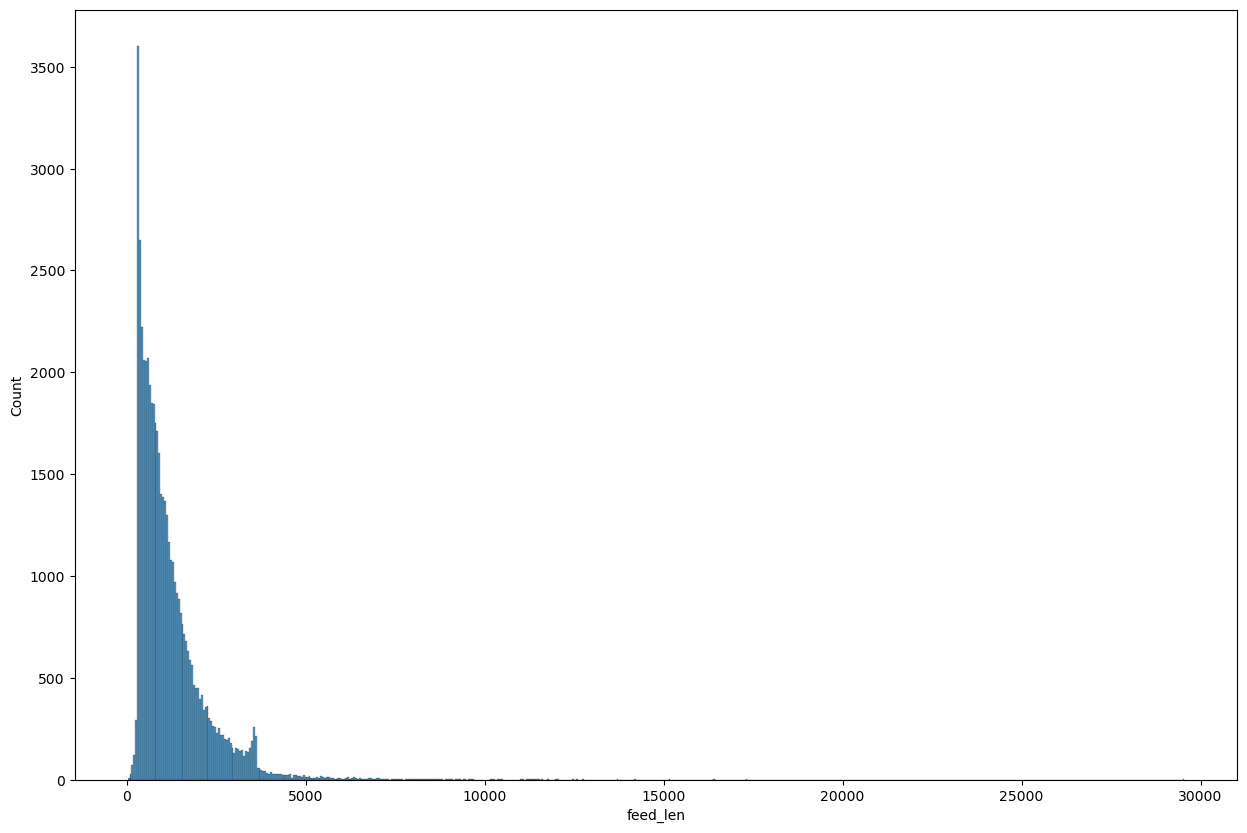

In [12]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df.feed_len)
plt.show()

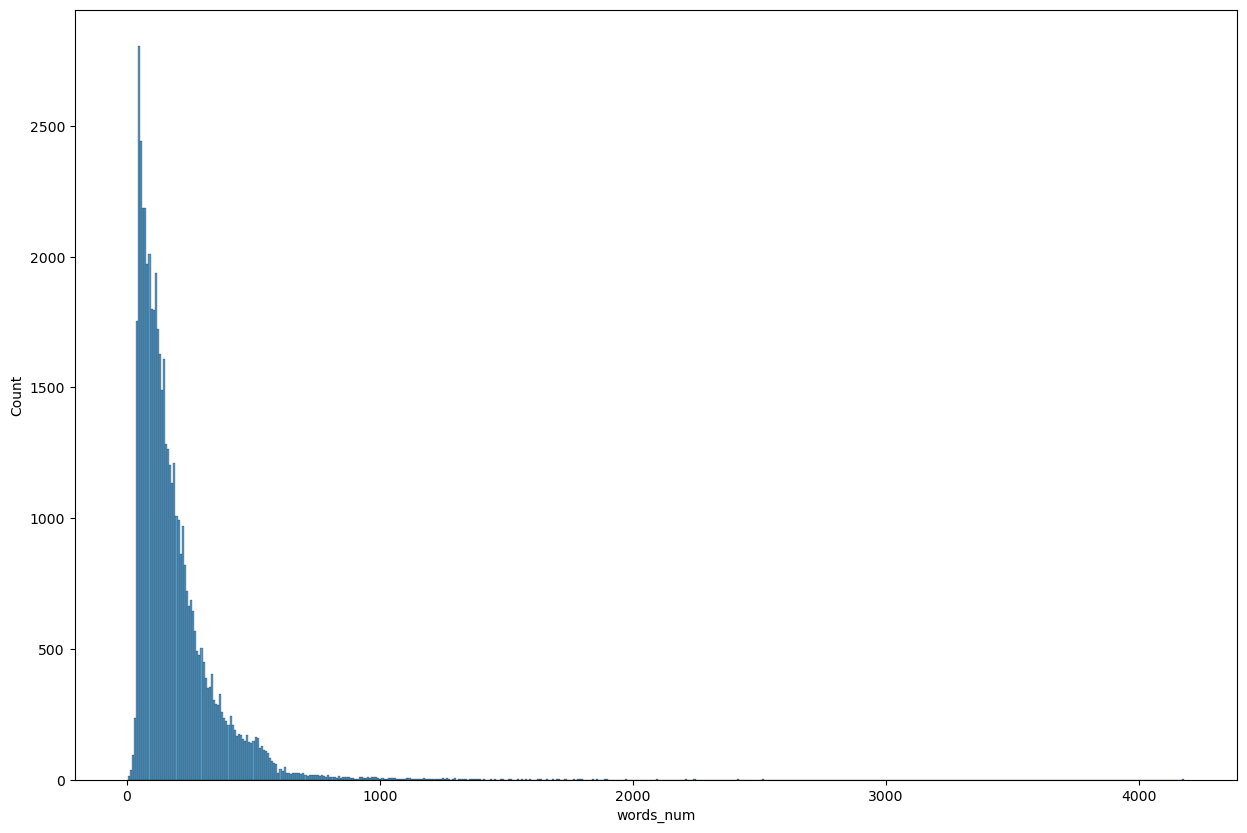

In [13]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df.words_num)
plt.show()

видим длинные хвосты у обоих распределений

In [14]:
df[['feeds', 'feed_len', 'words_num']]

,feeds,feed_len,words_num
0,"Много лет являюсь клиентом этого банка, но пос...",1286,197
1,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",1000,158
4,"Имею потребительский кредит, взятый в Связь-ба...",1614,230
7,Хочу выразить глубокую благодарность всем сотр...,438,53
8,"6 марта 2019г. В 10:33 при проходе в метро ""Ку...",1175,186
...,...,...,...
74995,Три года длится эпопея с закрытием кредитной к...,563,90
74996,"Являлся клиентом Бинбанка, пока после слияния ...",1007,150
74997,8 мая 2016 г. мною вносились деньги на банковс...,1223,190
74998,Здравствуйте! Сегодня 21.04.2020 захожу в моби...,400,57


In [15]:
# Приведем распределения к нормальному
df['ln_feed_len'] = np.log(df['feed_len'])
df['ln_words_num'] = np.log(df['words_num'])

array([[<Axes: title={'center': 'feed_len'}>,
        <Axes: title={'center': 'ln_feed_len'}>],
       [<Axes: title={'center': 'words_num'}>,
        <Axes: title={'center': 'ln_words_num'}>]], dtype=object)

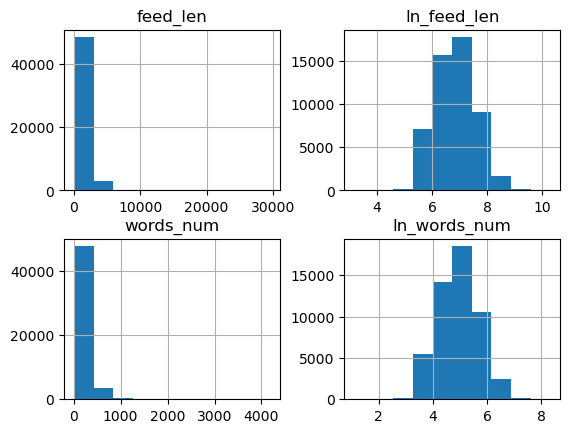

In [16]:
df[['feed_len', 'ln_feed_len', 'words_num', 'ln_words_num']].hist()

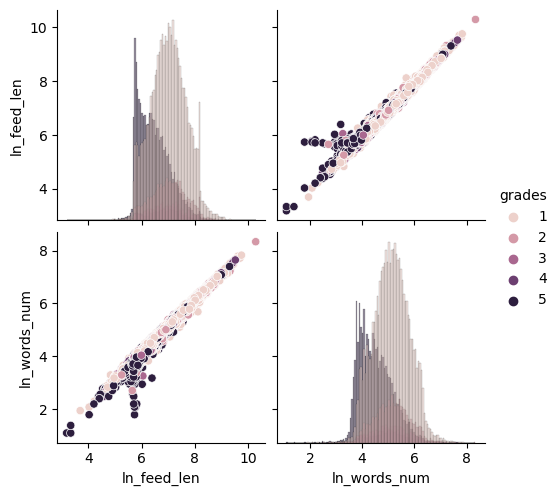

In [38]:
sns.pairplot(df[['ln_feed_len', 'ln_words_num', 'grades']], hue="grades", diag_kind="hist")

# Отзывы с высокой оценкой как правило короче, а с низкой - длиннее

### Обрабатываем текст

In [39]:
r = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_rus = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()

def lemmatize(text):
    text = re.sub(r, ' ', text)
    tokens = []
    for token in text.split():
        if token not in stopwords_rus:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    
    return ' '.join(tokens)

In [28]:
df['lemmas'] = df['feeds'].apply(lemmatize)
df[['feeds', 'lemmas']]

In [35]:
df.drop(columns=['date', 'feed_len', 'words_num', 'feeds'], axis=1, inplace=True)
df

,bank,feeds,grades,year,month,day,time_day,feed_len,words_num,ln_feed_len,ln_words_num,lemmas
0,ubrr,"Много лет являюсь клиентом этого банка, но пос...",1,2017,2,16,afternoon,1286,197,7.159292,5.283204,"[много, год, являться, клиент, банк, последний..."
1,fk_otkritie,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",2,2016,12,13,night,1000,158,6.907755,5.062595,"[г, ростов, дон, ул, ленин, быть, г, час, в, д..."
4,promsvyazbank,"Имею потребительский кредит, взятый в Связь-ба...",2,2020,8,4,morning,1614,230,7.386471,5.438079,"[иметь, потребительский, кредит, взять, связь,..."
7,homecreditbank,Хочу выразить глубокую благодарность всем сотр...,5,2015,4,19,evening,438,53,6.082219,3.970292,"[хотеть, выразить, глубокий, благодарность, ве..."
8,vtb,"6 марта 2019г. В 10:33 при проходе в метро ""Ку...",2,2019,3,28,evening,1175,186,7.069023,5.225747,"[март, г, в, проход, метро, курский, социальны..."
...,...,...,...,...,...,...,...,...,...,...,...,...
74995,trust,Три года длится эпопея с закрытием кредитной к...,1,2016,10,26,morning,563,90,6.333280,4.499810,"[три, год, длиться, эпопея, закрытие, кредитны..."
74996,fk_otkritie,"Являлся клиентом Бинбанка, пока после слияния ...",2,2020,2,1,evening,1007,150,6.914731,5.010635,"[являться, клиент, бинбанка, пока, слияние, пе..."
74997,sberbank,8 мая 2016 г. мною вносились деньги на банковс...,1,2016,6,14,afternoon,1223,190,7.109062,5.247024,"[май, г, я, вноситься, деньга, банковский, кар..."
74998,uralsib,Здравствуйте! Сегодня 21.04.2020 захожу в моби...,3,2020,4,21,morning,400,57,5.991465,4.043051,"[здравствуйте, сегодня, заходить, мобильный, б..."


In [40]:
df_test = pd.read_csv('new_test_ml.csv', index_col=0)
df_test.feeds.sample(20)

14789    Наша компания сотрудничает с Альфа банком с 20...
7476     27.11.2020г. Подписываю договор ипотеки с банк...
7618     Являюсь клиентом банка уже много лет. За это в...
13403    Я в Совкомбанк ходу уже лет 10 точно, сейчас т...
10821    Мне, 10.02.2017, прислали перевод "Золотая Кор...
792       07.10.2020 16:14 06.10.2020 в 18:12 Пришел в ...
14339    Имею кредитный договор последние цифры /100300...
1934     31 января 2017 обратился в операционный офис "...
15576    На основании кредитной истории в банке в начал...
5830     Оплатила с кредитной карты товар в интернет-ма...
12415    Выражаю огромную благодарность куратору Сберба...
424      Хочу выразить благодарность сотруднице Сбербан...
364      Добрый день. Хочу начать описание своего отзыв...
3499     Очень интересно всё получилось. Я подал заявку...
8789     19 декабря 2016 г. пришла в отделение банка ВТ...
1791     У меня закончился вклад в банке. Встала задача...
16412    Хочу выразить благодарность специалисту банка .

In [42]:
df_test['date']

0        01.07.2020 10:53
1        20.06.2019 13:19
2        20.02.2016 11:46
3        06.05.2019 15:48
4        23.05.2016 15:41
               ...       
17215    22.09.2018 16:08
17216     06.10.2011 9:35
17217    21.08.2019 14:13
17218    29.05.2020 16:12
17219    02.06.2015 15:44
Name: date, Length: 17220, dtype: object

In [43]:
df_test['date'] = pd.to_datetime(df_test['date'], format='%d.%m.%Y %H:%M')

df_test['year'] = df_test['date'].apply(lambda x: x.year)
df_test['month'] = df_test['date'].apply(lambda x: x.month)
df_test['day'] = df_test['date'].apply(lambda x: x.day)
df_test['time_day'] = df_test['date'].apply(lambda x: time_of_day(x.hour))

df_test['feed_len'] = df_test.feeds.apply(len) 
df_test['ln_feed_len'] = np.log(df_test['feed_len'])

df_test['words_num'] = df_test.feeds.apply(lambda x: len(x.split()))
df_test['ln_words_num'] = np.log(df_test['words_num'])

df_test['lemmas'] = df_test['feeds'].apply(lemmatize)

df_test.drop(columns=['date', 'feed_len', 'words_num', 'feeds', 'inds'], axis=1, inplace=True)

In [82]:
df_test

,bank,year,month,day,time_day,ln_feed_len,ln_words_num,lemmas
0,sberbank,2020,7,1,morning,5.802118,3.806662,оформлять ипотека сбербанк подгрузить необходи...
1,alfabank,2019,6,20,afternoon,6.954639,5.049856,краткий содержание рекомендовать брать кредит ...
2,v-express-bank,2016,2,20,morning,6.594413,4.682131,добрый день уважаемый сотрудник служба контрол...
3,homecreditbank,2019,5,6,afternoon,6.028279,4.110874,обращаться получение карта зелёный польза сотр...
4,vtb,2016,5,23,afternoon,7.828038,5.942799,обратиться отделение банк проспект ленин отдел...
...,...,...,...,...,...,...,...,...
17215,sberbank,2018,9,22,afternoon,6.579251,4.736198,о ва к к снимать сын деньга мой карта сбербанк...
17216,homecreditbank,2011,10,6,morning,7.081709,5.257495,наверняка засчитать менее нужный срочно неболь...
17217,interprombank,2019,8,21,afternoon,7.977968,6.054439,физ лицо обратиться офис университетский просп...
17218,otpbank,2020,5,29,afternoon,6.037871,4.007333,у банк рекламный продукт игра мой рыбка быть н...


## Подбор оптимальных гиперпараметров

In [56]:
from sklearn.model_selection import train_test_split

df_train_val = df[['bank', 'lemmas', 'year', 'month', 'day', 'time_day', 'ln_feed_len', 'ln_words_num']]
y_train_val = df['grades']
X_train, X_val, y_train, y_val = train_test_split(df_train_val, y_train_val, train_size=0.7)  

In [70]:
#from sklearn.metrics import f1_score
#import optuna

#def objective(trial):
#    params = {
#        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01)
#    }

#    model = CatBoostClassifier(**params, silent=True, iterations = 300,
#                               cat_features=['bank', 'time_day', 'year', 'month', 'day'],
#                               text_features=['lemmas'], eval_metric='MultiClass')
#    model.fit(X_train, y_train)
#    predictions = model.predict(X_val)
#    f1 = f1_score(y_val, predictions, average='micro')
#    return f1

#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=10)

In [71]:
#print('Best hyperparameters:', study.best_params)
#print('Best f1_score:', study.best_value)

### Интерпретация

In [91]:
model = CatBoostClassifier(iterations = 300, learning_rate=0.009, silent=True, 
                           cat_features=['bank', 'time_day', 'year', 'month', 'day'],
                           text_features=['lemmas'], eval_metric='MultiClass')

In [92]:
model.fit(X_train, y_train)
predictions = model.predict(X_val)

f1_score(y_val, predictions, average='micro')

0.74169526646377

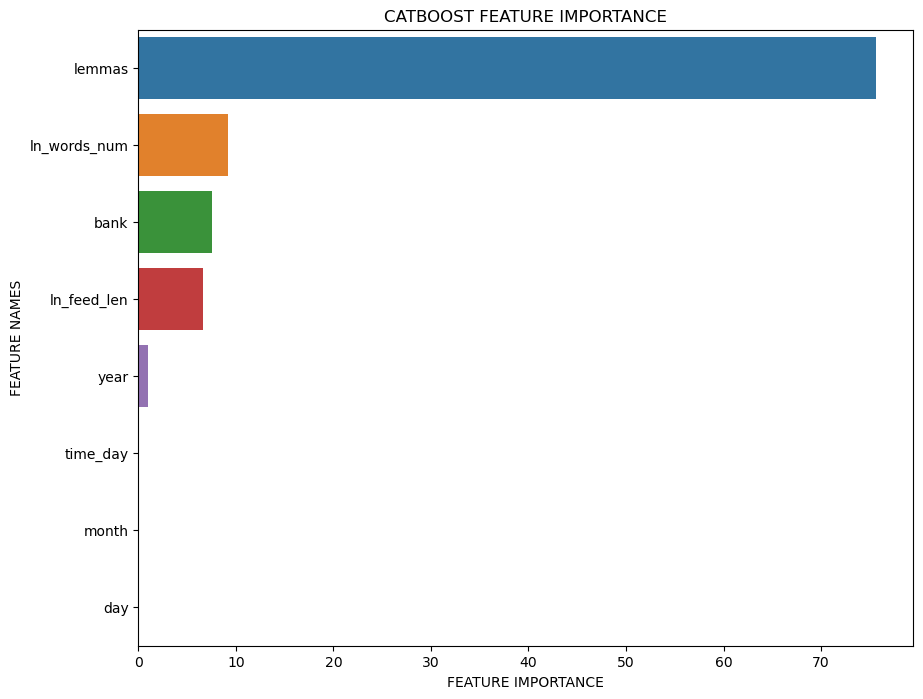

In [93]:
def plot_feature_importance(importance,names,model_type):
    
    #Создаем датафрейм из названий признаков - их значимости
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi = pd.DataFrame(data)
    
    #Сортируем значения от большего к меньшему
    fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Строим график
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi['feature_importance'], y=fi['feature_names'])
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model.get_feature_importance(), X_train.columns, 'CATBOOST')

- видим, что время написания отзыва не связано с тем, будет он негативным или нет
- также видим, что с помощью текста действительно можно предсказывать оценку, которую поставит пользователь (самая важная фича - лемматизированный текст)
- возможно, если оставить знаки препинания, то по различным скобочкам и т.п. можно будет еще лучше понимать эмоциональную окраску отзыва и, следовательно, лучше предсказывать оценку
- также название банка сильно связано с тем, какой будет отзыв - положительный или отрицательный, что логично, так как если в банке есть какая-либо проблема, то столкнувшиеся с ней люди более вероятно будут писать плохие отзывы (следовательно, будет много негативных отзывов на один и тот же банк)

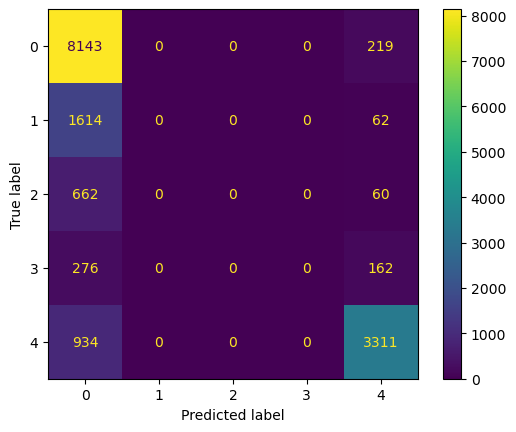

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

- лучше всего предсказываются негативные оценки
- хуже всего предсказываются оценки в середине, так как их было мало в выборке. возможно, помогло бы увеличение количества итераций в catboost и более тщательный подбор гиперпараметров, но это сильно повышает нагрузку на компьютер
- в целом если важно выявлять именно очень плохие отзывы, то модель работает неплохо

**также нужно учитывать наличие иронии в текстах отзывов**, например отзыв 

_"Отвратительно. Пытался заполнить платежное поручение в Сбербанк Онлайн для отправки платежа Юр Лицу на счет также в Сбербанке. Не получилось. Позвонил в центр обслуживания. Мало того, что 1й раз меня скинули, так еще и рассказали, что через Онлайн систему можно отправлять не все платежи (даже не смотря на то, что это внутрибанковский перевод). Так что идите и стойте в очереди в отделении. Очень удобно. Спасибо."_

сочетает в себе слова и "отвратительно", и "очень удобно", "спасибо". Человеку понятно, что отзыв негативный (просто по описанию ситуации) и что слова про удобство это ирония, а моделям машинного обучения это понять уже тяжело, тем более что явно позитивных слов даже больше, чем явно негативных.

### выгружаем предсказания для kaggle

In [101]:
X_train.dtypes

bank             object
lemmas           object
year              int64
month             int64
day               int64
time_day         object
ln_feed_len     float64
ln_words_num    float64
dtype: object

In [102]:
df_test = df_test[['bank', 'lemmas', 'year', 'month', 'day', 'time_day', 
                   'ln_feed_len', 'ln_words_num']]

In [103]:
pred = model.predict(df_test)

submit = pd.DataFrame({'inds': df_test.index,
                       'grades': pred.flatten()})
submit

,inds,grades
0,0,5
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
17215,17215,1
17216,17216,1
17217,17217,1
17218,17218,1


In [105]:
submit.to_csv('pred_.csv', index=False)

# на kaggle эта модель выдает стабильный скор в примерно 0.74 (совпадает с полученным тут на тесте)
# 0.74332 - на public и 0.74758 - на private

Можно предположить, что более высокий скор можно получить, не обрабатывая так сильно текст, так как мы наблюдаем наличие иронии и важность знаков препинания для определения эмоциональной окраски отзыва. Попробуем другую модель и не будем обрабатывать данные (попытки обработать данные приводят к ухудшению качества)

In [109]:
df_2 = pd.read_csv('train_ml.csv')
df_2.dropna(inplace=True)

X = df_2["feeds"] 
y = df_2['grades']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, train_size=0.7, random_state=42)

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vectorized_x_train = tfidf_vectorizer.fit_transform(X_train2)

In [114]:
from sklearn.svm import SVC

svm = SVC(kernel='sigmoid', C = 0.99,  random_state = 42)
svm.fit(tfidf_vectorized_x_train, y_train2)

SVC(C=0.99, kernel='sigmoid', random_state=42)

In [115]:
tfidf_vectorized_x_test = tfidf_vectorizer.transform(X_test2)

pred_test = svm.predict(tfidf_vectorized_x_test)
f1_score(y_test2, pred_test, average='micro')

0.789613417082173

In [116]:
df_test = pd.read_csv('new_test_ml.csv')
df_test.drop('Unnamed: 0', axis=1, inplace=True)

X_test1 = df_test['feeds']

In [117]:
tfidf_vectorized_x_test1 = tfidf_vectorizer.transform(X_test1)
tfidf_vectorized_x_test1

pred_2 = svm.predict(tfidf_vectorized_x_test1)
pred_2

array([1., 1., 1., ..., 1., 1., 1.])

In [125]:
submit_2 = pd.DataFrame({'inds': df_test.index,
                       'grades': pred_2.flatten()})

submit_2 = submit_2.astype({'grades': np.int64})
submit_2

,inds,grades
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
17215,17215,1
17216,17216,1
17217,17217,1
17218,17218,1


In [126]:
submit_2.to_csv('pred__2.csv', index=False)

# на kaggle эта модель выдает более высокий скор (даже выше полученного тут на тесте):
# 0.79605 - на public и 0.7986 - на private